In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from autoencoder_utils import MI_between, NMI_between, corr_between

In [3]:
names_m = ['Period', 'Duration', 'Time of Transit Epoch', 'r/R', 'a/R',
       'Inclination', 'Impact Parameter', 'Fitted Stellar Density',
       'Limb Darkening Coeff1', 'Limb Darkening Coeff2']

#### Metadatos Extraídos de la curva de luz
Generados a través de best-fit parámetros de un ajuste Mandel-Agol
* 1) Period 
> asociado al tiempo entre repeticiones o extensión de la órbita
* 3) Time of Transit Epoch (T0)
> tiempo en que inicia el tránsito
* 4) r/R
> Radio del planeta indica la profunidad del tránsito
* 5) a/R
> Radio de órbita indica qué tan alejado está el planeta de estrella, se refleja en la duración del tránsito (mayor radio órbita => menor duracion tránsito) .
* 6) Inclination 
> ángulo de inclinación indica el ángulo entre el plano perpendicular a la estrella y de la estrella al planeta (si =90, órbita es perpendicular a la visión) -- (mayor inclination => mayor duración tránsito y mayor luz bloqueada)
* 9) Limb Darkening Coeff1 (con cross-matching)
* 10) Limb Darkening Coeff2 (con cross-matching)
> Asociados al decaimiento de luz producido en los bordes de la estrella (no son un cuerpo negro) -- indica qué tan circular es el tránsito y las "subidas" en los extremos
* Eccentricity y Periastron no fueron calculados (todos null) 

Extras (*Ningún cálculo es lineal*):
* 2) Duration 
> duración de eclipse. **Calculado** en base al periodo, radio órbita y radio planeta $d \propto p *sin^{-1}(r/a)$
* 7) Impact Parameter (circular)
> distancia del planeta al eje de visión de estrella. **Calculado** en base a radio órbita e inclination (a*cos(i))
* 8) Fitted Stellar Density
> **Calculado** en base al periodo, radio de planeta y duración de eclipse (see Seager and Mallen-Ornelas 2003).


En base a estrella:
* Teq 
> temperatura de equilibrio del planeta, cálculos necesitan info d la estrella.
* Teff
* Stellar Radius
* Stellar Mass
> temperatura efectiva, radio y masa de la estrella madre. (generados con *cross-matching*)

Docu: https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html  
refs:  
https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/  
https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/pyaslDoc/aslDoc/transitDuration.html  
https://cds.cern.ch/record/560538/files/0206228.pdf

### All Metadata

In [4]:
names_m = ["Period", "Duration", "Time of Transit Epoch", "r/R", "a/R","Inclination", "Impact Parameter", 
            "Fitted Stellar Density", "Limb Darkening Coeff1", "Limb Darkening Coeff2"]

x_meta = np.load("../obj4/LC_features/MetadataLC.npy") #solo las 10 asociadas a la curva
#re-ordenar
aux = pd.DataFrame(x_meta, columns=names_m)
names_m = ["Period", "Time of Transit Epoch", "r/R", "a/R","Inclination", "Limb Darkening Coeff1", "Limb Darkening Coeff2",
           "Duration", "Impact Parameter", "Fitted Stellar Density"]
x_meta = aux[names_m].values

print("data shape=",x_meta.shape)

data shape= (8054, 10)


In [5]:
star_names_m = ["Teq","Teff","Stellar Radius", "Stellar Mass"] #añado la que usa estrella --metallicity?

df_meta = pd.read_csv("../../KOI_Data/koi_metadata.csv")
df_meta_obj = df_meta[star_names_m]

#fill nans
mask_cand = df_meta["NExScI Disposition"] == "CANDIDATE"
cand_nans = np.any(pd.isna(df_meta_obj[mask_cand]))
df_meta_obj[mask_cand] = df_meta_obj[mask_cand].fillna(df_meta_obj[mask_cand].median(),inplace=False)
mask_fp = df_meta["NExScI Disposition"] == "FALSE POSITIVE"
cand_fp = np.any(pd.isna(df_meta_obj[mask_fp]))
df_meta_obj[mask_fp] = df_meta_obj[mask_fp].fillna(df_meta_obj[mask_fp].median(),inplace=False)

x_meta_star = df_meta_obj.values
print("data shape=",x_meta_star.shape)

data shape= (8054, 4)


/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/pandas/core/frame.py:2957: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(indexer, value)
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

In [5]:
all_names_m = names_m + star_names_m

x_all_meta = np.concatenate([x_meta,x_meta_star], axis=1)
print("data shape=",x_all_meta.shape)

data shape= (8054, 14)


In [6]:
def summary_features(a):    
    res = pd.DataFrame()
    res["Features"] = ["feat-"+str(value) for value in np.arange(1,1+ len(a))]
    #res["Corr - Mean (7)"] = a[:,:7].mean(axis=-1)
    res["Mean abs (7)"] = np.abs(a[:,:7]).mean(axis=-1)
    #res["Mean (10)"] = a[:,:10].mean(axis=-1)
    res["Mean abs (10)"] = np.abs(a[:,:10]).mean(axis=-1)
    #res["Mean (all)"] = a.mean(axis=1)
    res["Mean abs (all)"] = np.abs(a).mean(axis=1)
    
    res = res.sort_values(by=["Mean abs (7)"], ascending=False) #retornar ordenado por correlacion a los 7 "raw"
    res.reset_index(drop=True, inplace=True)
    
    res.loc[len(a)] = ["Global", 
                         res["Mean abs (7)"].mean(),
                         res["Mean abs (10)"].mean(),
                         res["Mean abs (all)"].mean()]
    return res

In [7]:
latent_dim = 16 #o 32
T = 300 #unico ejecuutado

### Autoencoder

In [15]:
z_AE = np.load("./LC_features/AE_%dT_%dD.npy"%(T,latent_dim))
print("data shape=",z_AE.shape)

data shape= (8054, 16)


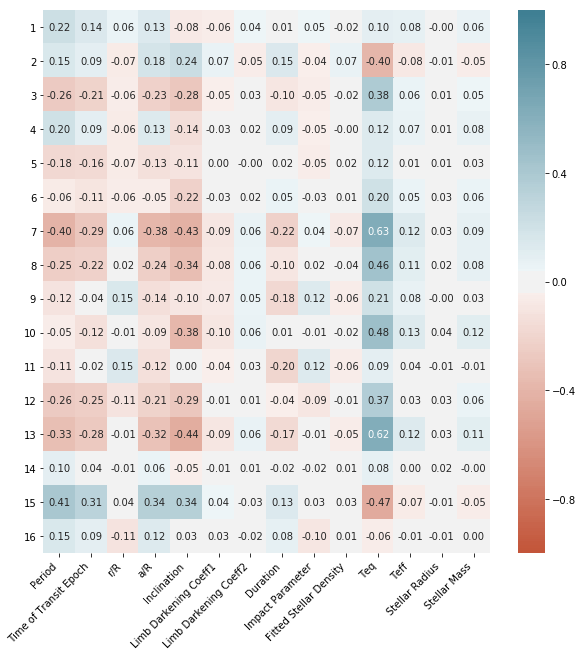

In [185]:
corr = corr_between(z_AE, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(np.arange(1,1+corr.shape[0]), rotation=0)
plt.show()

In [186]:
summary_features(corr)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-7,0.244798,0.205069,0.208710
1,feat-13,0.220290,0.177540,0.189269
2,feat-15,0.216627,0.171300,0.165356
3,feat-8,0.171389,0.135202,0.144972
4,feat-12,0.163874,0.129082,0.126277
5,feat-3,0.160093,0.128876,0.127776
6,feat-2,0.120755,0.110345,0.117525
7,feat-10,0.115526,0.084433,0.114337
8,feat-1,0.106047,0.082352,0.076293
9,feat-4,0.096580,0.081894,0.077971


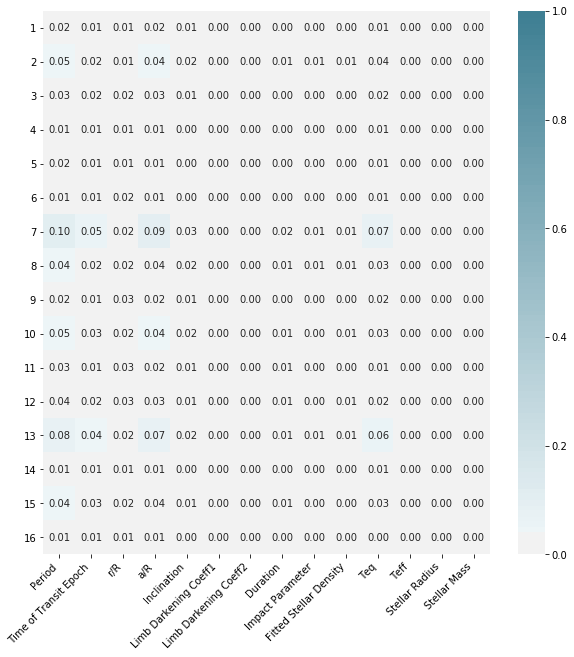

In [16]:
mut_inf = NMI_between(z_AE, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    mut_inf, 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(np.arange(1,1+mut_inf.shape[0]), rotation=0)

plt.show()

In [17]:
summary_features(mut_inf)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-7,0.043209,0.033118,0.029258
1,feat-13,0.034759,0.026311,0.023387
2,feat-10,0.024091,0.018706,0.016085
3,feat-2,0.021233,0.016683,0.014476
4,feat-15,0.020712,0.015722,0.013560
5,feat-8,0.020242,0.016075,0.014282
6,feat-12,0.018878,0.014974,0.012353
7,feat-3,0.015569,0.012148,0.010330
8,feat-11,0.013662,0.010948,0.008674
9,feat-9,0.013584,0.010955,0.009325


### Variational Autoencoder

In [11]:
z_VAE = np.load("./LC_features/VAE_%dT_%dD.npy"%(T,latent_dim))
print("data shape=",z_VAE.shape)

data shape= (8054, 16)


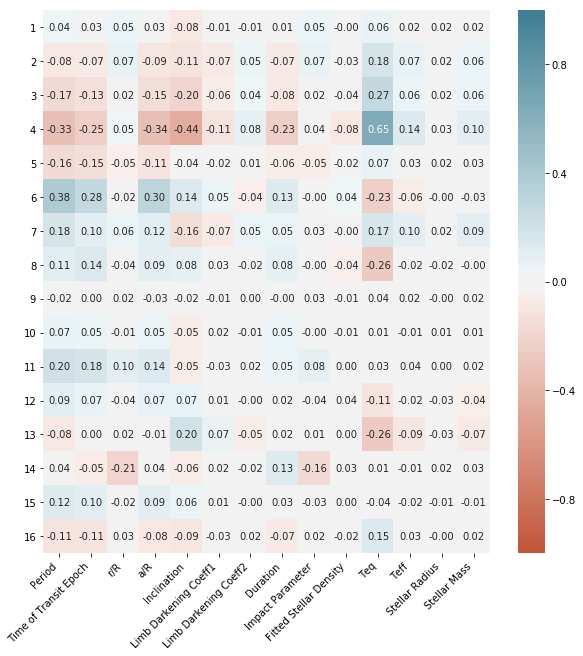

In [188]:
corr = corr_between(z_VAE, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(np.arange(1,1+corr.shape[0]), rotation=0)
plt.show()

In [189]:
summary_features(corr)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-4,0.227821,0.193604,0.203395
1,feat-6,0.172993,0.138215,0.121673
2,feat-3,0.112258,0.092711,0.095111
3,feat-11,0.103816,0.086560,0.068791
4,feat-7,0.103768,0.081170,0.084549
5,feat-2,0.079112,0.073505,0.075841
6,feat-5,0.075658,0.066462,0.058104
7,feat-8,0.072643,0.063906,0.067661
8,feat-16,0.069277,0.059845,0.056501
9,feat-14,0.062037,0.075663,0.058668


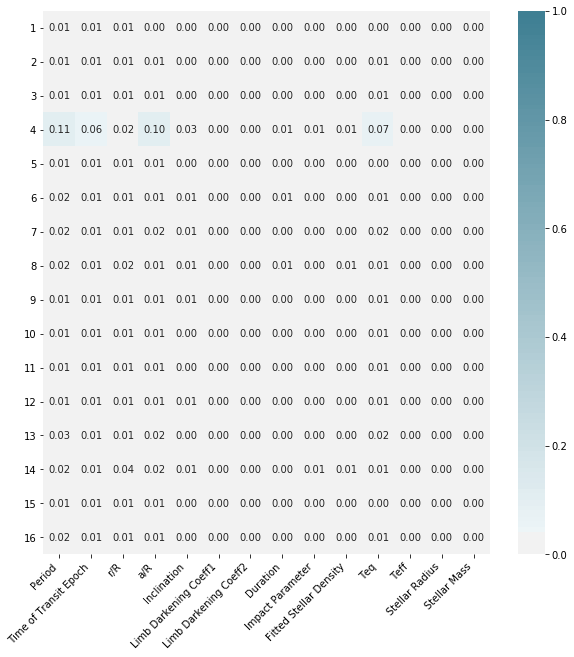

In [12]:
mut_inf = NMI_between(z_VAE, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    mut_inf, 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(np.arange(1,1+mut_inf.shape[0]), rotation=0)

plt.show()

In [14]:
summary_features(mut_inf)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-4,0.046214,0.035366,0.030977
1,feat-14,0.015120,0.012364,0.010128
2,feat-13,0.010437,0.007750,0.006941
3,feat-8,0.010085,0.008735,0.007427
4,feat-7,0.009672,0.007627,0.007112
5,feat-6,0.009668,0.007718,0.006653
6,feat-11,0.008607,0.006763,0.005759
7,feat-2,0.006925,0.005351,0.004651
8,feat-16,0.006843,0.005300,0.004701
9,feat-12,0.006652,0.005048,0.004179


### VAE + escala

In [8]:
z_VAEs = np.load("./LC_features/VAE_S_%dT_%dD.npy"%(T,latent_dim))
print("data shape=",z_VAEs.shape)

data shape= (8054, 16)


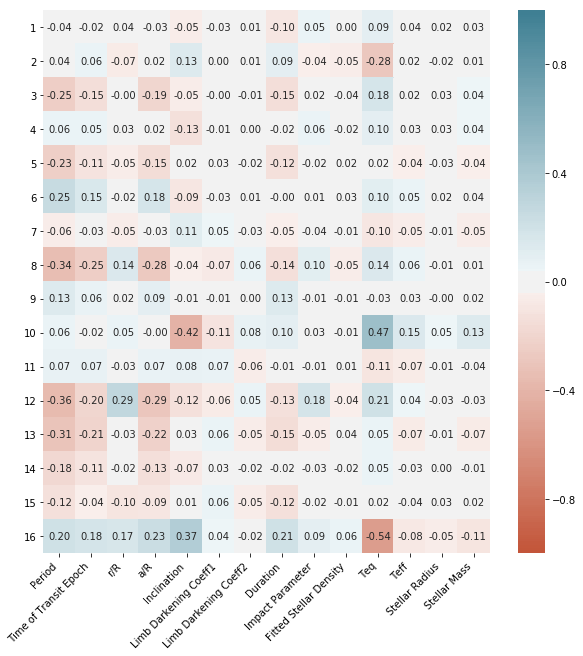

In [35]:
corr = corr_between(z_VAEs, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(np.arange(1,1+corr.shape[0]), rotation=0)

plt.show()

ahora si "pilla" mejor el r/R .. debido a que tiene la escala como input..

In [192]:
summary_features(corr)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-12,0.196809,0.172913,0.145688
1,feat-16,0.173331,0.157368,0.167762
2,feat-8,0.169500,0.148093,0.121908
3,feat-13,0.129860,0.114416,0.096445
4,feat-10,0.106202,0.088075,0.119449
5,feat-6,0.104184,0.077193,0.070623
6,feat-3,0.092936,0.085621,0.080543
7,feat-5,0.088090,0.077582,0.065380
8,feat-14,0.080387,0.063188,0.051251
9,feat-15,0.068911,0.063802,0.052783


Modelo VAE pareciera ser más independiente **linealmente** a los metadatos, quizás encuentre cosas más allá?

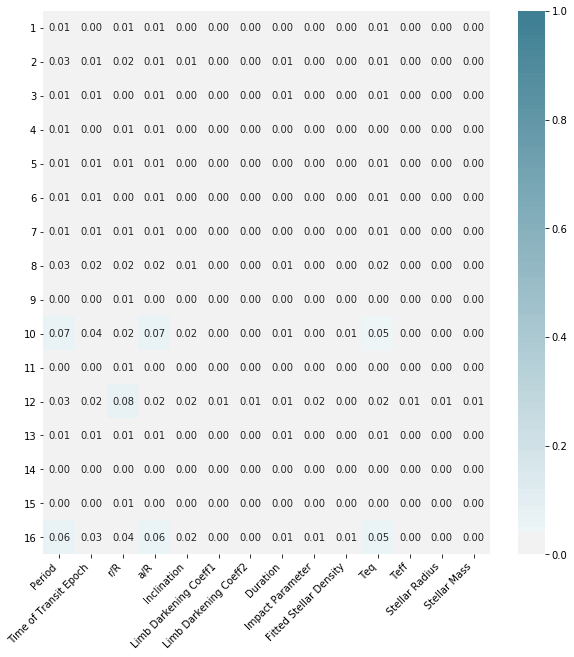

In [9]:
mut_inf = NMI_between(z_VAEs, x_all_meta)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    mut_inf, 
    vmin=0, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True, fmt=".2f",
)
ax.set_xticklabels(
    all_names_m,
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(np.arange(1,1+mut_inf.shape[0]), rotation=0)

plt.show()

In [10]:
summary_features(mut_inf)

,Features,Mean abs (7),Mean abs (10),Mean abs (all)
0,feat-16,0.031010,0.023788,0.021213
1,feat-10,0.030590,0.023874,0.020975
2,feat-12,0.026520,0.021994,0.018374
3,feat-8,0.013563,0.010591,0.009144
4,feat-2,0.011974,0.010545,0.008830
5,feat-13,0.006165,0.005259,0.004400
6,feat-6,0.006011,0.004425,0.004062
7,feat-3,0.005535,0.004509,0.003946
8,feat-1,0.004702,0.003774,0.003238
9,feat-5,0.004635,0.003788,0.003280


### Generar curva en VAE, variando Z

In [39]:
## load data
T = 300

Slog_mu =  -10.4507
Slog_std =  1.0672

latent_dim = 16

Using TensorFlow backend.


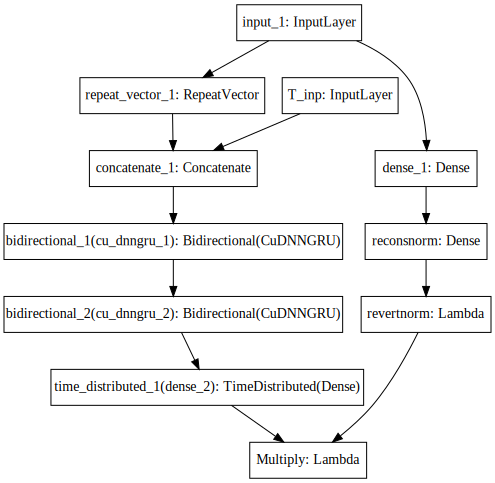

In [40]:
from autoencoder_utils import get_GRU, define_samp_model
from autoencoder_utils import Mul_L,  Div_L, Norm_L,  RevertNorm_L #scaled functions

from keras.layers import *
from keras.models import Model
##### INPUTS DECODER ######
z_sampled = Input(shape=(latent_dim,)) #z
x_t = Input(shape = (T, 1) , name ="T_inp")

##### RECONSTRCT SCALE ######
s_out = Dense(2, activation='tanh')(z_sampled)
s_out = Dense(1, activation='linear', name="reconsnorm")(s_out) #NEW: aprende s 
s_out = Lambda(RevertNorm_L, arguments={'mu':Slog_mu,'std':Slog_std},name="revertnorm")(s_out) #NEW: volver a escala normal 

##### RECONSTRUCT LIGHT CURVE ######
decode = RepeatVector(T)(z_sampled)
decode = Concatenate(axis=-1)([x_t, decode]) #add time decode
decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(get_GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
decode = Lambda(Mul_L, name="Multiply")([decode, s_out]) #NEW: recuperar escala de dato (multiplicar por std)
generator = Model([x_t, z_sampled], decode, name="generator")

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(generator).create(prog='dot', format='svg'))

In [41]:
## load model..
generator.load_weights("./models/VAE_S_%dT_%dD_%de_D.h5"%(T,latent_dim,300))

### Basado en curva promedio

In [90]:
n = 10 #data to generate

#op1:
z_base = np.zeros(latent_dim) #prior -- NO SIRVE (el modelo no apredne eso)

#op2:
z_base = np.mean(z_VAEs, axis=0) #mean of all data (real p(z)) -- could be p(z|y)

#op3:
mask_transit = np.load("data/mask_transit_LC.npy")  # transit behavior
z_base = np.mean(z_VAEs[mask_transit], axis=0) #mean of all transit data  (real trained p(z))


#op4:
#mask_conf = df_meta["NExScI Disposition"] == "CONFIRMED"
#z_sampleds = np.mean(z_VAEs[mask_conf], axis=0) #mean of confirmeds -- "regular behavior"


z_base = np.tile(z_base, (n,1)) #repetir n-veces
z_base.shape

(10, 16)

In [91]:
z_base

array([[ 0.10391694,  0.7034868 , -0.0024822 , -0.05771336,  0.06110627,
         0.00578531,  0.2646483 ,  0.79116094, -0.15039816, -1.1240726 ,
         0.01064567,  0.5340014 ,  0.4278372 ,  0.01489906, -0.0166119 ,
        -0.6693306 ],
       [ 0.10391694,  0.7034868 , -0.0024822 , -0.05771336,  0.06110627,
         0.00578531,  0.2646483 ,  0.79116094, -0.15039816, -1.1240726 ,
         0.01064567,  0.5340014 ,  0.4278372 ,  0.01489906, -0.0166119 ,
        -0.6693306 ],
       [ 0.10391694,  0.7034868 , -0.0024822 , -0.05771336,  0.06110627,
         0.00578531,  0.2646483 ,  0.79116094, -0.15039816, -1.1240726 ,
         0.01064567,  0.5340014 ,  0.4278372 ,  0.01489906, -0.0166119 ,
        -0.6693306 ],
       [ 0.10391694,  0.7034868 , -0.0024822 , -0.05771336,  0.06110627,
         0.00578531,  0.2646483 ,  0.79116094, -0.15039816, -1.1240726 ,
         0.01064567,  0.5340014 ,  0.4278372 ,  0.01489906, -0.0166119 ,
        -0.6693306 ],
       [ 0.10391694,  0.7034868 , -0

In [162]:
X_fold_time = np.load("data/Time_global_%dT.npy"%T)
idx_X = np.arange(X_fold_time.shape[0])

### necesito un tiempo de referencia..
idx_random = np.random.choice(idx_X, size=n, replace=False)
time_i = X_fold_time[idx_random][:,:,None]
time_i.shape

(10, 300, 1)

### Curva "promedio"

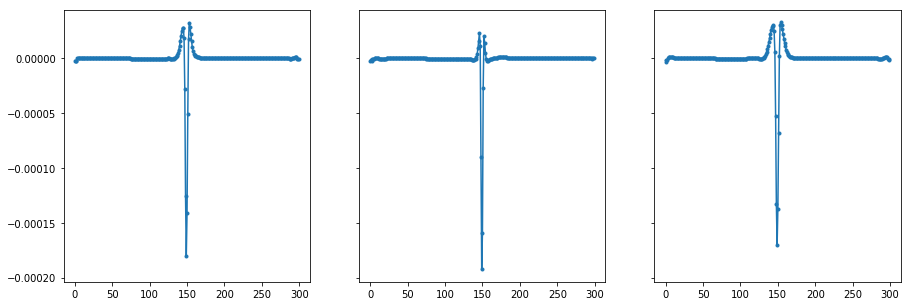

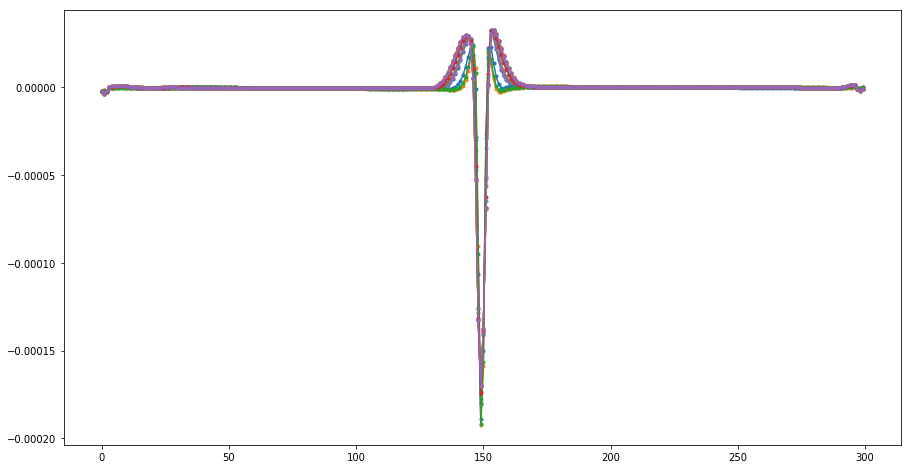

In [49]:
## generate random
x_decoded = generator.predict([time_i, z_base])


f, axx = plt.subplots(1, 3, sharey=True,figsize= (15,5))
for i in range(3): #plot by side mejor
    axx[i].plot(x_decoded[i,:,0], '.-')
plt.show()
    

plt.figure(figsize=(15,8))
for i in range(n):
    plt.plot(x_decoded[i,:,0], '.-')
plt.show()

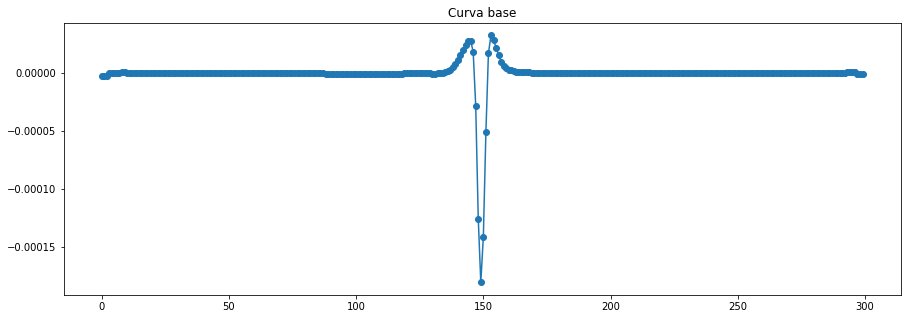

In [115]:
time_set_i = np.tile(time_i[0], (n,1,1))
x_base = generator.predict([time_set_i[0:1], z_base[0:1]])[0]

plt.figure(figsize=(15,5))
plt.plot(x_base, 'o-')
plt.title("Curva base")
plt.show()

In [126]:
def visualize_gen(gen, time, z, name="", original=[]):
    x_decoded = gen.predict([time, z])

    f, axx = plt.subplots(1, 5, sharey=True,figsize= (15,4))
    for i in range(len(axx)): #plot by side mejor
        axx[i].plot(x_decoded[i,:,0], '.-')
        axx[i].set_title("Generation "+name+" "+str(i))
    plt.show()

    plt.figure(figsize=(15,7))
    for i in range(n):
        plt.plot(x_decoded[i,:,0], 'o-')
    
    if len(original) != 0:
        plt.plot(original, 'k-.', label="Original", alpha=0.9)
    
    plt.title("Overlapping "+name)
    plt.legend()
    plt.show()

In [155]:
## move feat -j
j = 8

In [146]:
z_sampleds = z_base.copy()
z_sampleds[:,j-1] = np.random.normal(0, 1, size=(n)) #different sampled values..

In [147]:
z_grid = z_base.copy()

from scipy import stats
cdf_traversal = np.linspace(0.05, 0.95, n)
z_grid[:,j-1] = stats.norm.ppf(cdf_traversal) ## grid sample

#### Menos correlacionadas

Feat-1


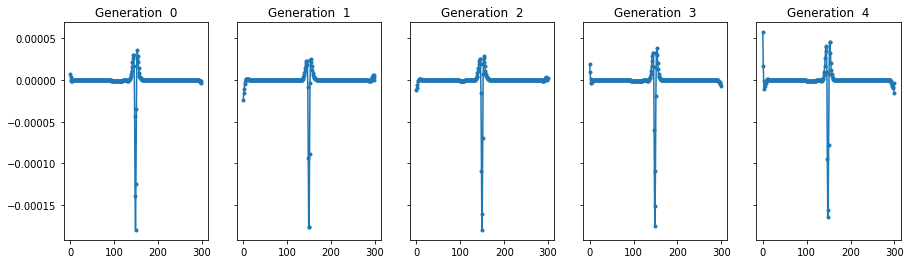

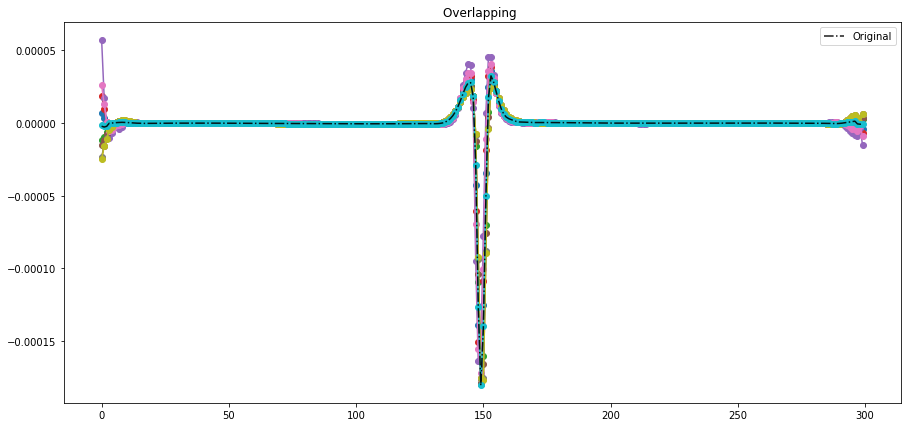

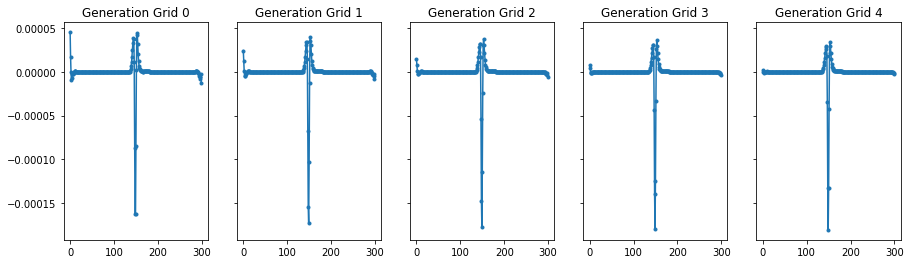

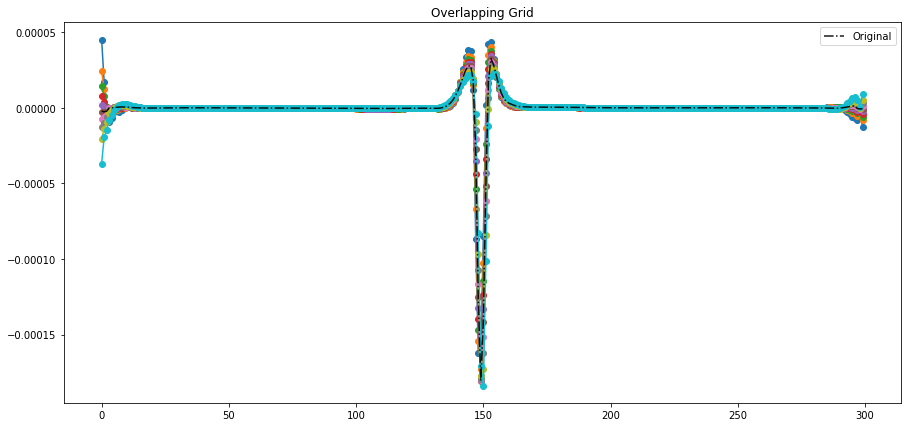

In [148]:
print("Feat-"+str(j))

visualize_gen(generator, time_set_i, z_sampleds, original=x_base)

visualize_gen(generator, time_set_i, z_grid, name="Grid", original=x_base)

al parecer relacionado con el ruido de los bordes

Feat-4


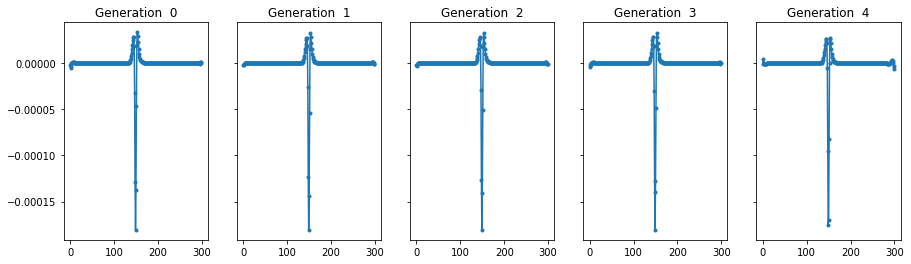

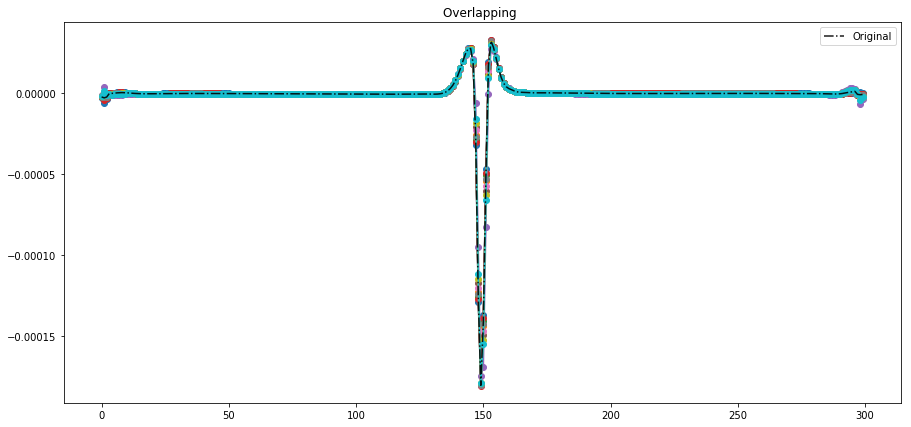

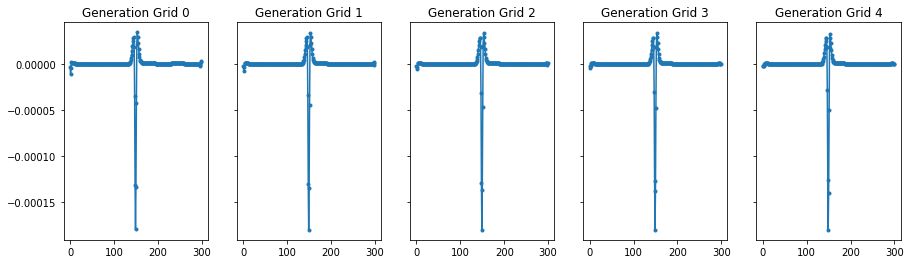

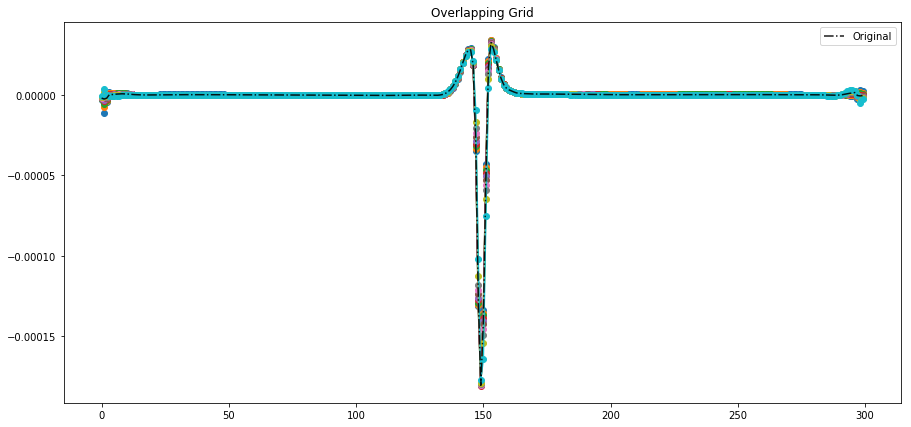

In [127]:
print("Feat-"+str(j))

visualize_gen(generator, time_set_i, z_sampleds, original=x_base)

visualize_gen(generator, time_set_i, z_grid, name="Grid", original=x_base)

al parecer relacionado con un "shift" de los valores en la curva, quizáś asociado a un "delta" de ruido en los tiempos

Feat-2


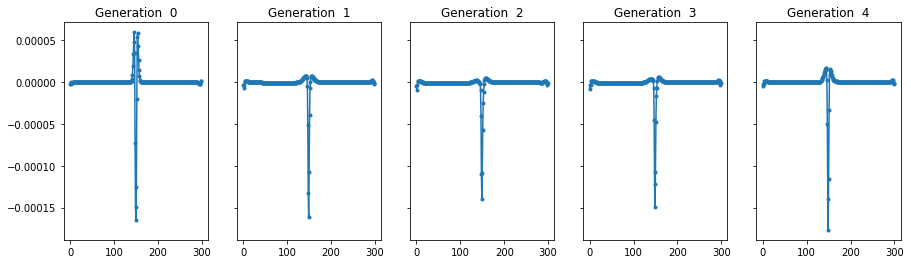

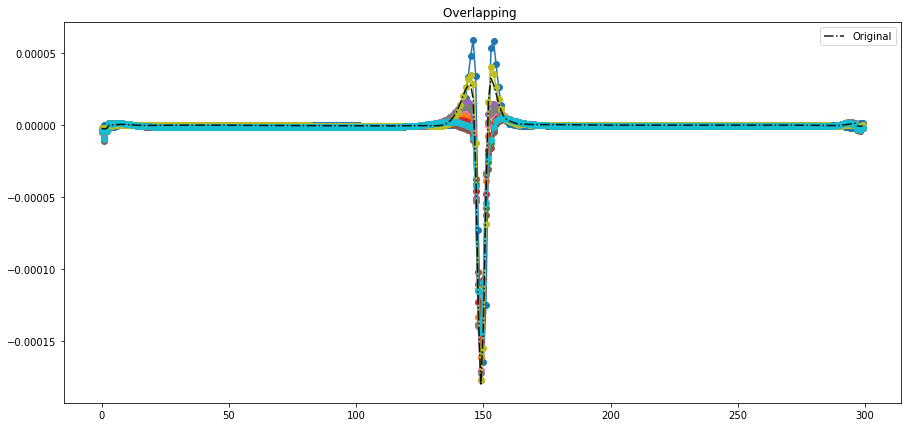

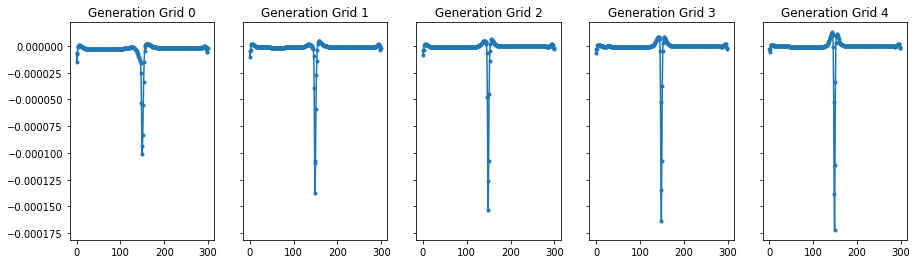

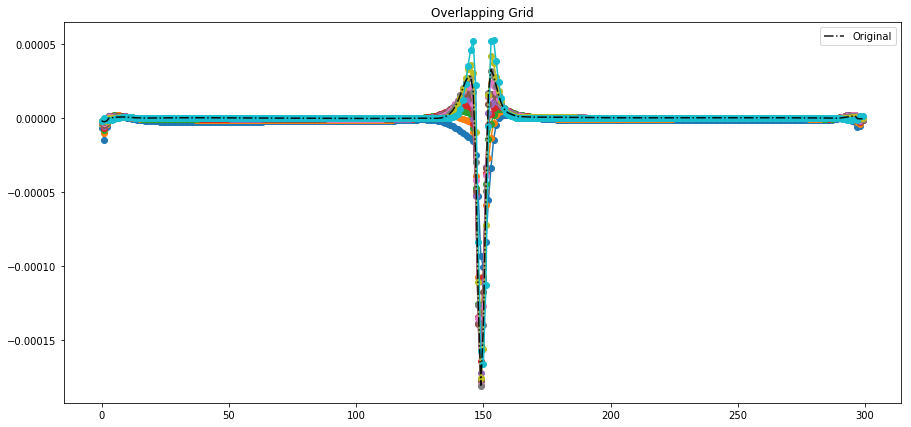

In [131]:
print("Feat-"+str(j))

visualize_gen(generator, time_set_i, z_sampleds, original=x_base)

visualize_gen(generator, time_set_i, z_grid, name="Grid", original=x_base)

al parecer relacionado con las variaciones en los comienzo y final de transito (ingress y egress), 

#### más correlacionadas

Feat-12


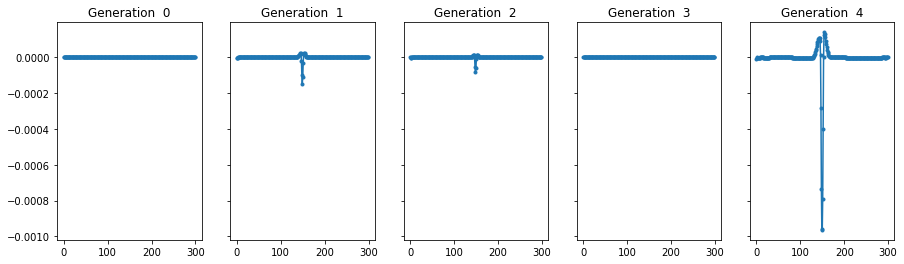

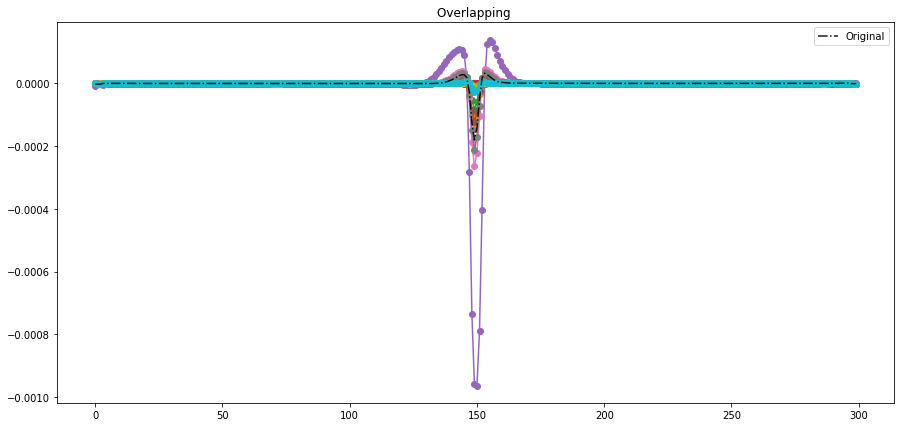

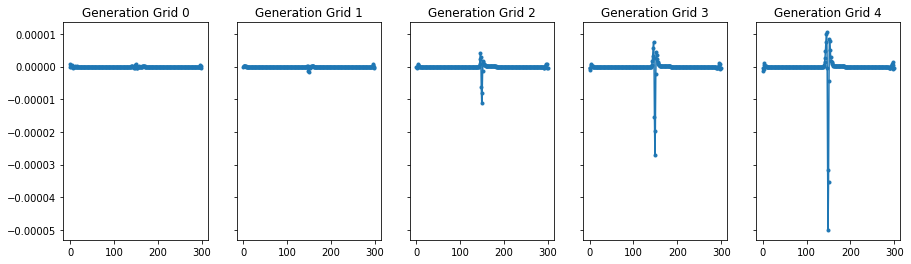

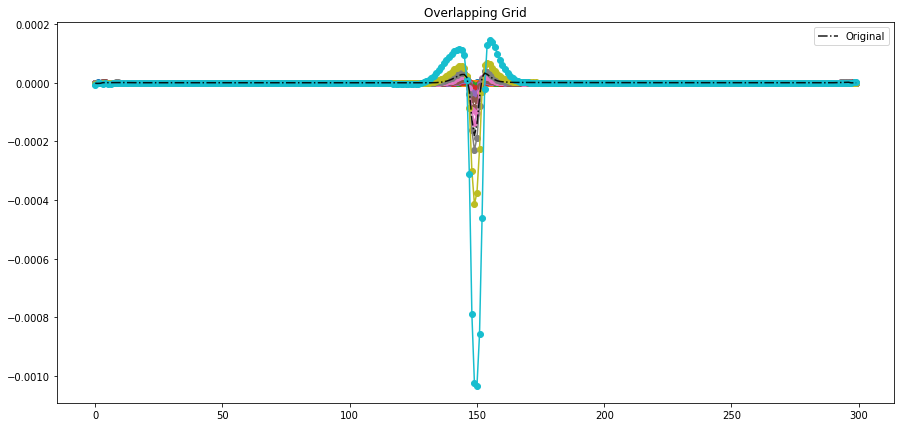

In [135]:
print("Feat-"+str(j))

visualize_gen(generator, time_set_i, z_sampleds, original=x_base)

visualize_gen(generator, time_set_i, z_grid, name="Grid", original=x_base)

mismo transit duration para diferentes objetos, por lo que varía el radio del planeta, radio de orbita y periodo.
ej: 
* un planeta que gira más rápido (periodo pequeño) que otro (pero mismo transit duration), debe tener radio de orbita bajo o radio planeta grande, para que demore lo mismo en el eclipse

Feat-16


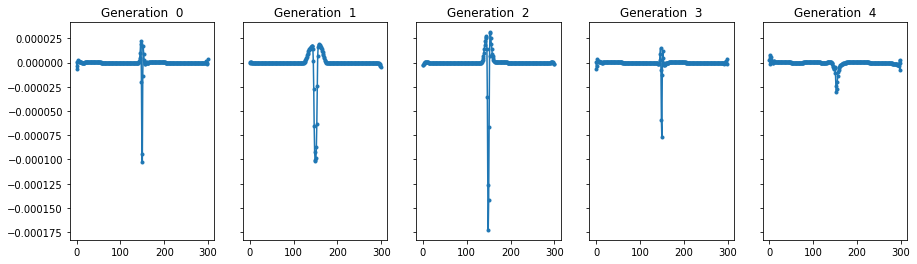

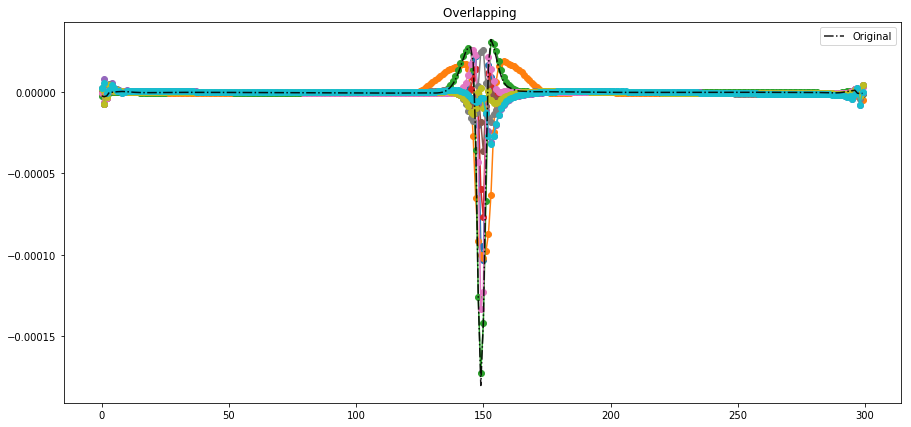

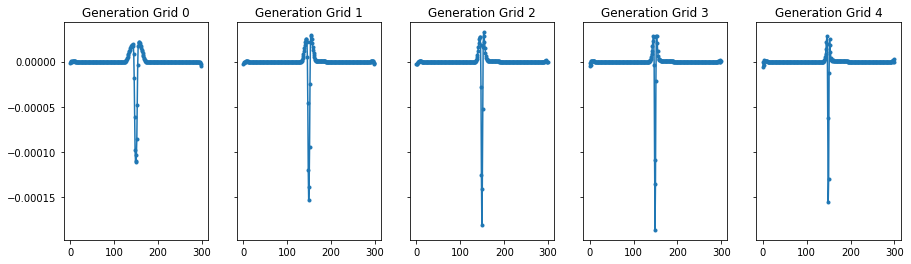

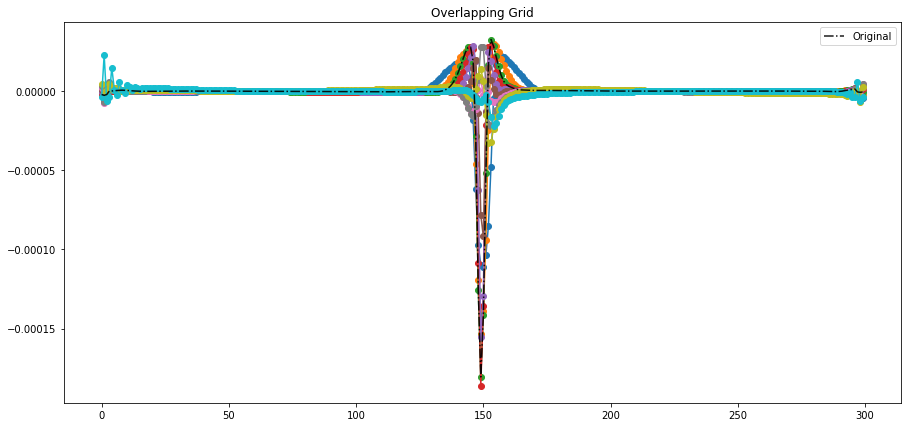

In [139]:
print("Feat-"+str(j))

visualize_gen(generator, time_set_i, z_sampleds, original=x_base)

visualize_gen(generator, time_set_i, z_grid, name="Grid", original=x_base)

varía casi todo

Feat-8


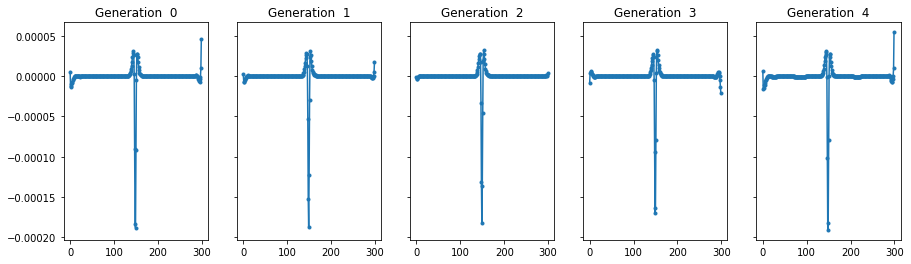

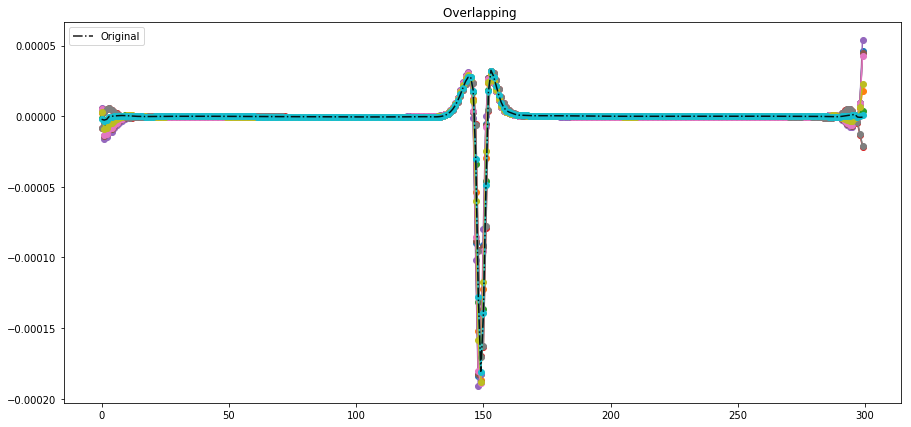

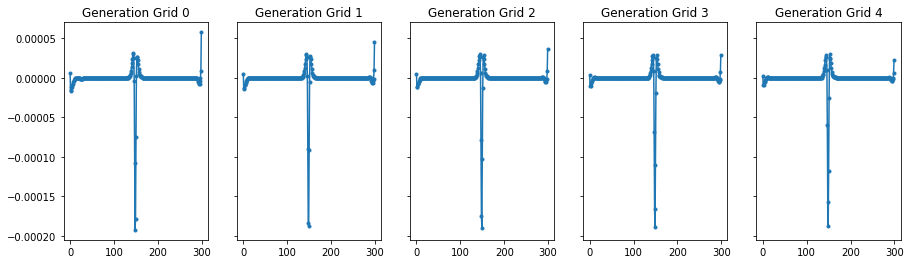

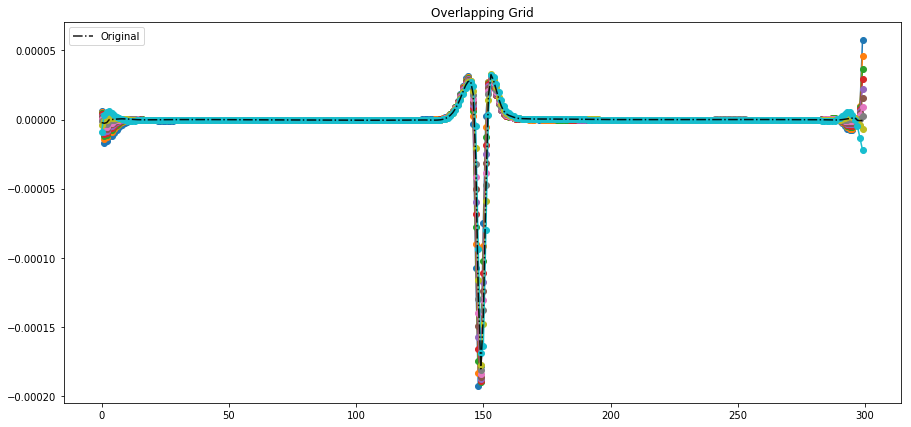

In [143]:
print("Feat-"+str(j))

visualize_gen(generator, time_set_i, z_sampleds, original=x_base)

visualize_gen(generator, time_set_i, z_grid, name="Grid", original=x_base)

bastante similar a feat 1

### Basado en curva real

In [230]:
n = 5

#a random sampled input (light curve editing)
idxs_samp = np.random.choice(np.sum(mask_transit), size=n, replace=False)
z_base = z_VAEs[mask_transit][idxs_samp] 

X_fold_time = np.load("data/Time_global_%dT.npy"%T)
### necesito un tiempo de referencia..
time_i = X_fold_time[mask_transit][idxs_samp][:,:,None]

x_base = generator.predict([time_i, z_base])

z_base.shape

(5, 16)

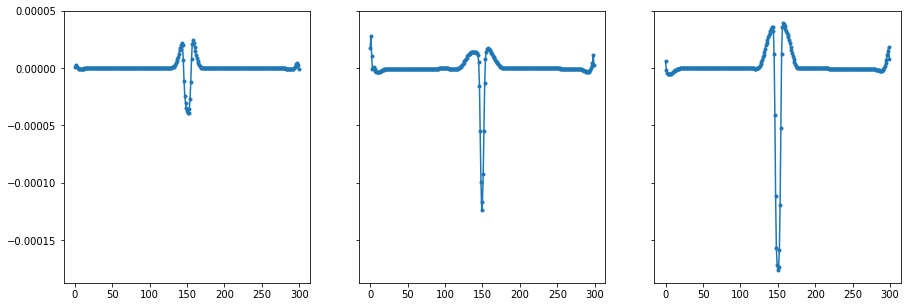

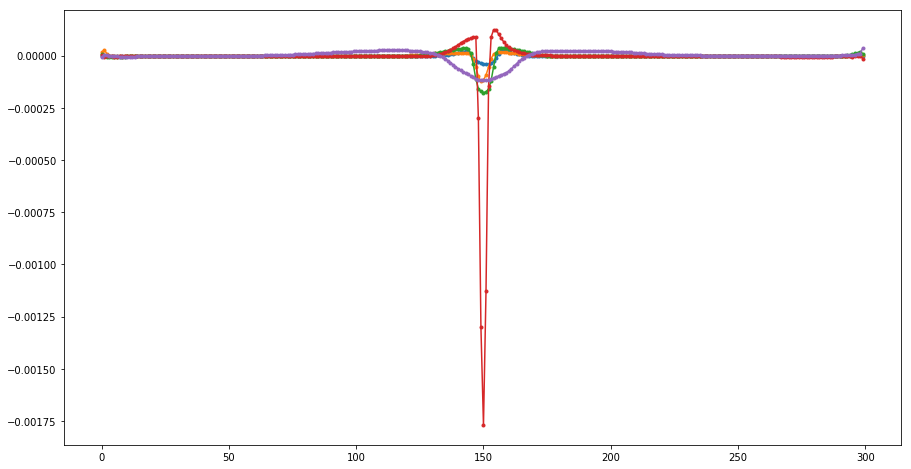

In [231]:
## generate random
x_decoded = generator.predict([time_i, z_base])


f, axx = plt.subplots(1, 3, sharey=True,figsize= (15,5))
for i in range(3): #plot by side mejor
    axx[i].plot(x_decoded[i,:,0], '.-')
plt.show()
    

plt.figure(figsize=(15,8))
for i in range(n):
    plt.plot(x_decoded[i,:,0], '.-')
plt.show()

In [232]:
from scipy import stats

def visualize_gen_LC(gen, Ts, Zs, name="", original=[]):
    cdf_traversal = np.linspace(0.05, 0.95, 10)
    D = Zs.shape[1]
    
    for i in range(Zs.shape[0]): #
        f, axx = plt.subplots(1, 7, sharey=True,figsize= (17,4))
        axx[0].plot(original[i,:,0], '.-', alpha=0.9)
        axx[0].set_title("Original")
        for j in range(1,len(axx)):
            z_grid = Zs[i][None,:].copy()
            z_grid = np.tile(z_grid, (10, 1)) #repetir n-veces
            z_grid[:,j-1] = stats.norm.ppf(cdf_traversal) ## grid sample
            t = np.tile(Ts[i], (10, 1, 1)) #repetir n-veces
            x_decoded = gen.predict([t, z_grid])
            
            for aux in x_decoded:
                axx[j].plot(aux[:,0], '.-')
            axx[j].set_title("Generation "+name+" feat-"+str(j))
        plt.yticks([])
        plt.show()
        
        f, axx = plt.subplots(1, 7, sharey=True,figsize= (17,4))
        for j in range(0,len(axx)):
            z_grid = Zs[i][None,:].copy()
            z_grid = np.tile(z_grid, (10, 1)) #repetir n-veces
            z_grid[:,j+7] = stats.norm.ppf(cdf_traversal) ## grid sample
            t = np.tile(Ts[i], (10, 1, 1)) #repetir n-veces
            x_decoded = gen.predict([t, z_grid])
            
            for aux in x_decoded:
                axx[j].plot(aux[:,0], '.-')
            axx[j].set_title("Generation "+name+" feat-"+str(j+7))
        plt.yticks([])
        plt.show()

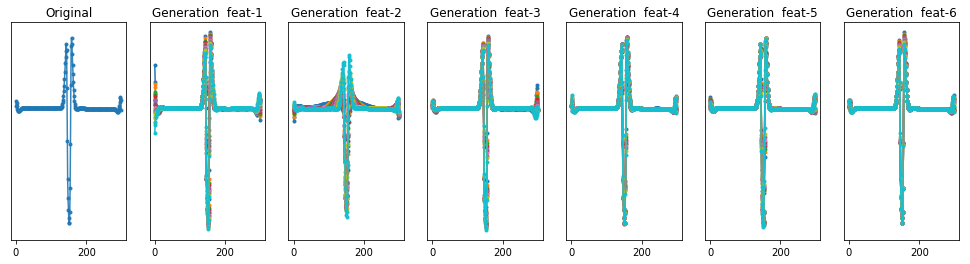

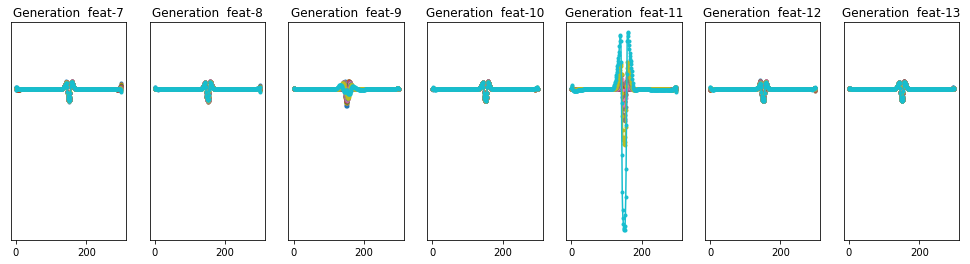

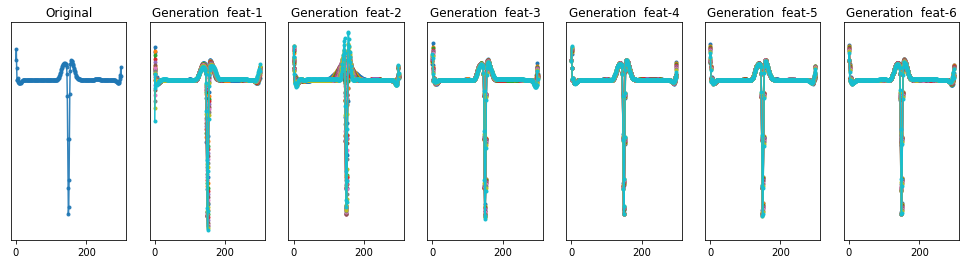

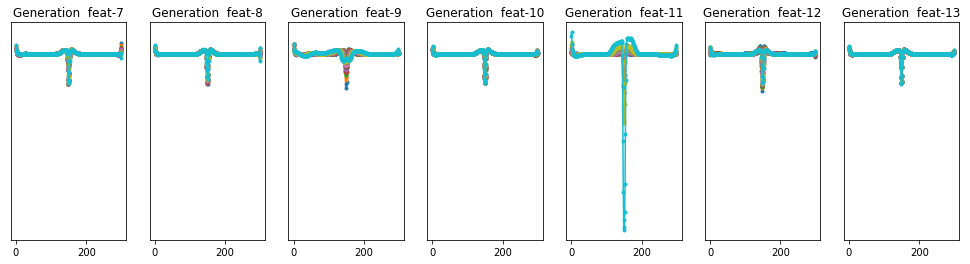

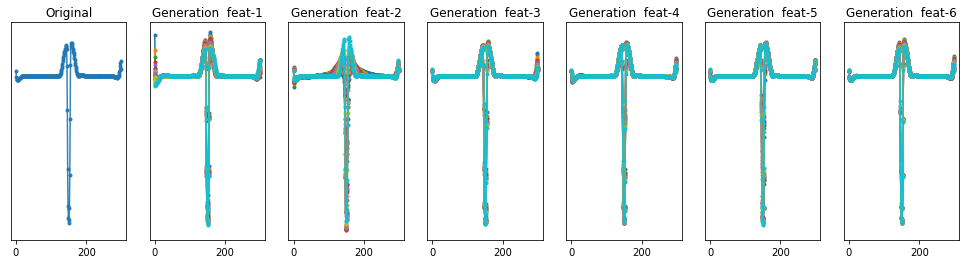

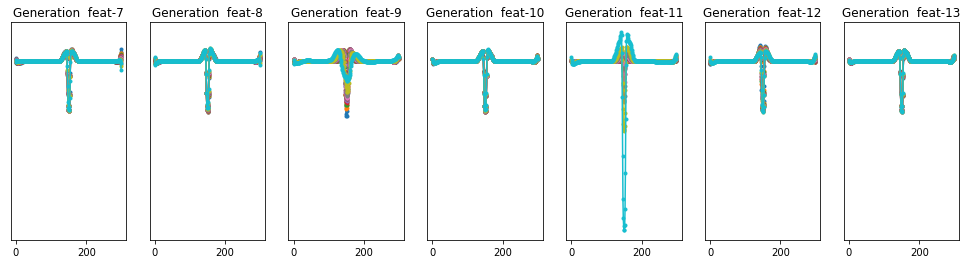

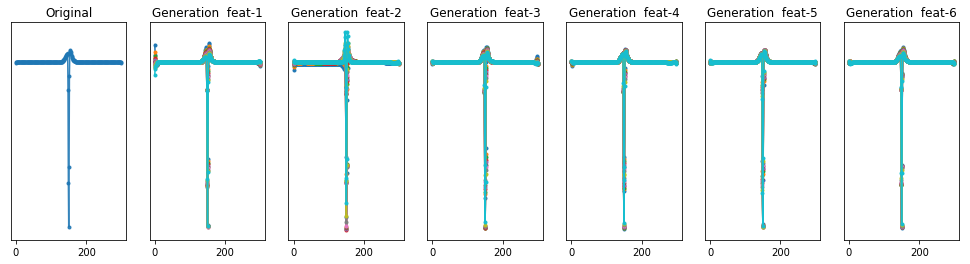

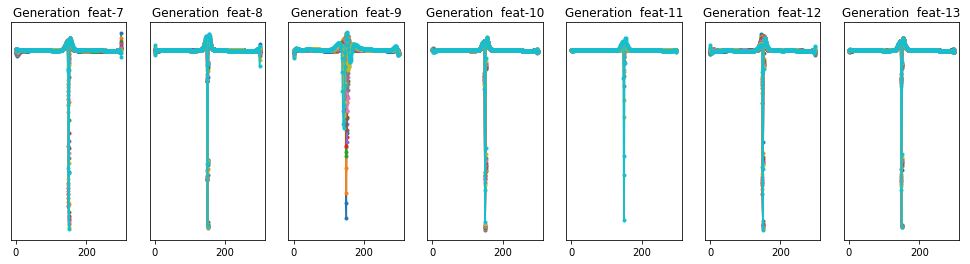

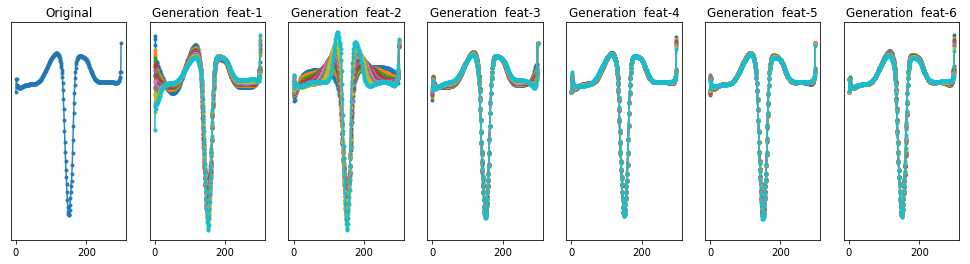

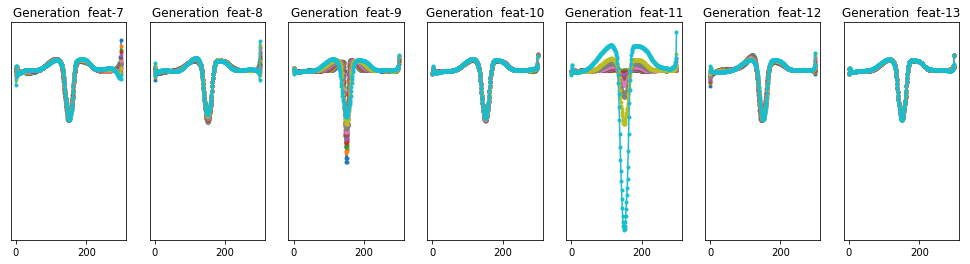

In [233]:
visualize_gen_LC(generator, time_i, z_base, name="", original=x_base)
